In [1]:
import numpy as np
import random
import os
import torch
import matplotlib.pyplot as plt
import torchvision as tv
import torch.nn as nn

In [2]:
def plot_compare(loss_history):
    plt.figure(figsize=(10, 6))
    for model_name, losses in loss_history["Train Loss"].items():
        plt.plot(losses, label=model_name)
    plt.title("Train Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()


    plt.figure(figsize=(10, 6))
    for model_name, losses in loss_history["Test Loss"].items():
        plt.plot(losses, label=model_name)
    plt.title("Test Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()


    plt.figure(figsize=(10, 6))
    for model_name, accs in loss_history["Test Acc"].items():
        plt.plot(accs, label=model_name)
    plt.title("Test Acc")
    plt.xlabel("Epoch)")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
l2_lambdas = [0, 1e-5, 1e-4, 1e-3, 1e-2, 0.1]

# 搭建数据集
train_data = tv.datasets.MNIST(
    root="./mnist_dataset",
    train=True,
    download=True,
    transform=tv.transforms.ToTensor(),
)
test_data = tv.datasets.MNIST(
    root="./mnist_dataset",
    train=False,
    download=True,
    transform=tv.transforms.ToTensor(),
)
batch_size = 64
train_iter = torch.utils.data.DataLoader(
    dataset=train_data, shuffle=True, batch_size=batch_size, num_workers=0
)
test_iter = torch.utils.data.DataLoader(
    dataset=test_data, shuffle=False, batch_size=batch_size, num_workers=0
)

任务一：手动实现L2正则化

In [4]:
from torch import Tensor

class MinistForwardNet(nn.Module):
    def __init__(self):
        super(MinistForwardNet, self).__init__()

        self.w1 = torch.nn.Parameter(torch.randn(28 * 28, 256))
        self.b1 = torch.nn.Parameter(torch.randn(256))
        self.w2 = torch.nn.Parameter(torch.randn(256, 10))
        self.b2 = torch.nn.Parameter(torch.randn(10))
        torch.nn.init.xavier_normal_(self.w1)
        torch.nn.init.constant_(self.b1, 0.1)
        torch.nn.init.xavier_normal_(self.w2)
        torch.nn.init.constant_(self.b2, 0.1)
        self.params = [self.w1, self.b1, self.w2, self.b2]

    def forward(self, x):
        x = torch.relu(torch.matmul(x, self.w1) + self.b1)
        x = torch.matmul(x, self.w2) + self.b2
        return x

In [5]:
nets = {}
for l2_lambda in l2_lambdas:
    nets[f"l2={l2_lambda}"] = (MinistForwardNet().to(device), l2_lambda)

loss_function = nn.CrossEntropyLoss()

loss_history = {
    "Train Loss": {},
    "Test Loss": {},
    "Test Acc": {},
}
num_epoch = 30

for net_name in nets:
    loss_history["Train Loss"][net_name] = []
    loss_history["Test Loss"][net_name] = []
    loss_history["Test Acc"][net_name] = []
    for epoch in range(30):
        net, l2_lambda = nets[net_name]
        optimizer = torch.optim.SGD(net.params, lr=0.01)
        train_loss_epoch, item_cnt = 0, 0
        for x, y in train_iter:
            x, y = x.to(device), y.to(device)
            x = x.view(-1, 28*28)

            pred = net(x)
            los = loss_function(pred, y)
            los += l2_lambda * torch.sum(net.w1**2)
            los.backward()
            optimizer.step()
            optimizer.zero_grad()
            train_loss_epoch += los.item()
            item_cnt += y.shape[0]

        train_loss_epoch /= item_cnt
        loss_history["Train Loss"][net_name].append(train_loss_epoch)
        with torch.no_grad():
            test_loss_epoch, test_acc_epoch, item_cnt = 0, 0, 0
            for x, y in test_iter:
                x, y = x.to(device), y.to(device)
                x = x.view(-1, 28*28)
                pred = net(x)
                los = loss_function(pred, y)
                test_loss_epoch += los.item()
                test_acc_epoch += (pred.argmax(dim=1).long() == y.long()).sum().item()
                item_cnt += y.shape[0]

        test_loss_epoch /= item_cnt
        loss_history["Test Loss"][net_name].append(test_loss_epoch)
        test_acc_epoch /= item_cnt
        loss_history["Test Acc"][net_name].append(test_acc_epoch)
        print(
            f"Epoch [{epoch + 1}/{num_epoch}], 模型: {net_name}, 训练损失: {train_loss_epoch:.4f}, 测试损失: {test_loss_epoch:.4f}, 测试准确率: {test_acc_epoch:.4f}"
        )

Epoch [1/30], 模型: l2=0, 训练损失: 0.0128, 测试损失: 0.0069, 测试准确率: 0.8881
Epoch [2/30], 模型: l2=0, 训练损失: 0.0063, 测试损失: 0.0054, 测试准确率: 0.9057
Epoch [3/30], 模型: l2=0, 训练损失: 0.0053, 测试损失: 0.0048, 测试准确率: 0.9142
Epoch [4/30], 模型: l2=0, 训练损失: 0.0048, 测试损失: 0.0044, 测试准确率: 0.9206
Epoch [5/30], 模型: l2=0, 训练损失: 0.0045, 测试损失: 0.0042, 测试准确率: 0.9243
Epoch [6/30], 模型: l2=0, 训练损失: 0.0042, 测试损失: 0.0039, 测试准确率: 0.9294
Epoch [7/30], 模型: l2=0, 训练损失: 0.0040, 测试损失: 0.0037, 测试准确率: 0.9324
Epoch [8/30], 模型: l2=0, 训练损失: 0.0038, 测试损失: 0.0036, 测试准确率: 0.9353
Epoch [9/30], 模型: l2=0, 训练损失: 0.0036, 测试损失: 0.0034, 测试准确率: 0.9380
Epoch [10/30], 模型: l2=0, 训练损失: 0.0034, 测试损失: 0.0033, 测试准确率: 0.9395
Epoch [11/30], 模型: l2=0, 训练损失: 0.0033, 测试损失: 0.0032, 测试准确率: 0.9439
Epoch [12/30], 模型: l2=0, 训练损失: 0.0032, 测试损失: 0.0030, 测试准确率: 0.9452
Epoch [13/30], 模型: l2=0, 训练损失: 0.0030, 测试损失: 0.0030, 测试准确率: 0.9464
Epoch [14/30], 模型: l2=0, 训练损失: 0.0029, 测试损失: 0.0029, 测试准确率: 0.9473
Epoch [15/30], 模型: l2=0, 训练损失: 0.0028, 测试损失: 0.0028, 测试准确率: 0.9497
Epoc

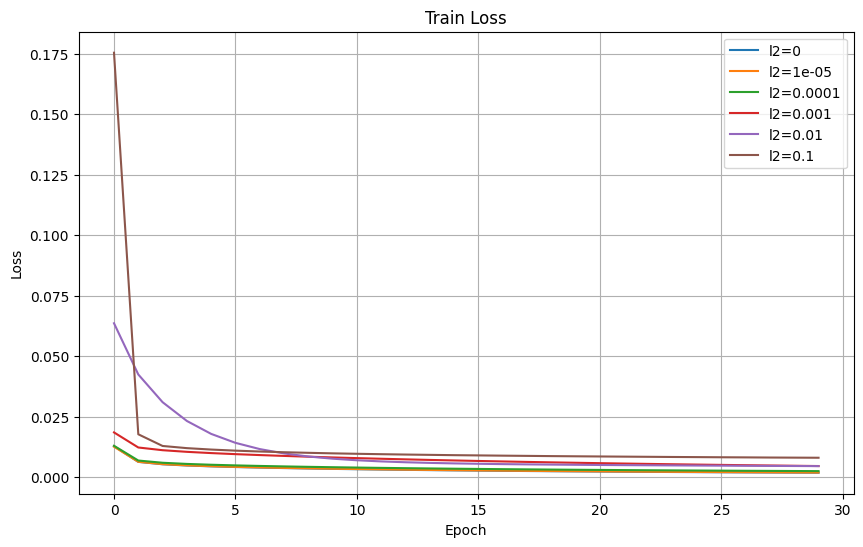

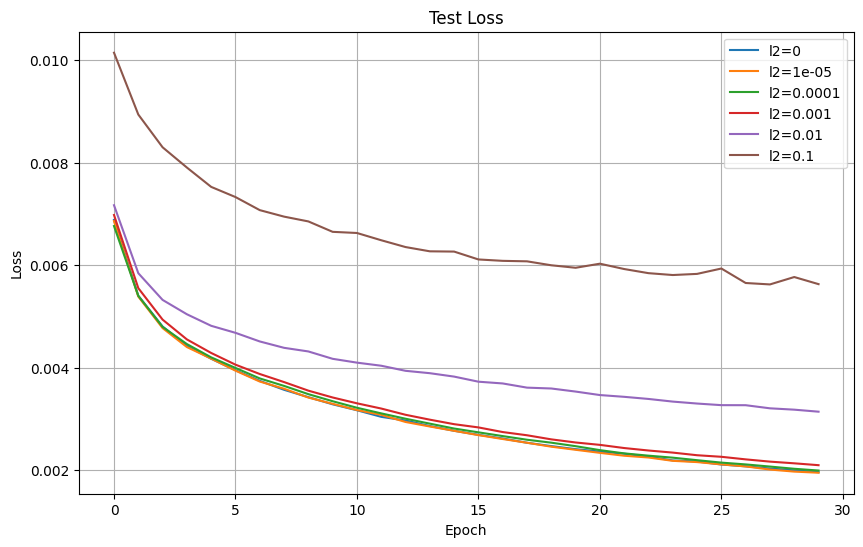

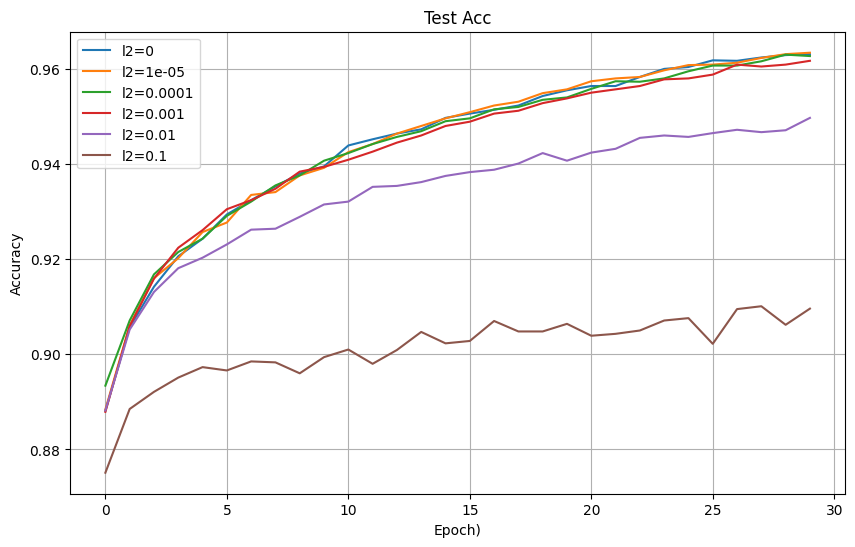

In [6]:
plot_compare(loss_history)

任务二：使用torch.nn实现L2正则化

In [7]:
nets = {}
for l2_lambda in l2_lambdas:
    nets[f"l2={l2_lambda}"] = (torch.nn.Sequential(
        nn.Flatten(),
        nn.Linear(784, 256),
        nn.ReLU(),
        nn.Dropout(l2_lambda),
        nn.Linear(256, 10),
    ).to(device), l2_lambda)

loss_function = nn.CrossEntropyLoss()

loss_history = {
    "Train Loss": {},
    "Test Loss": {},
    "Test Acc": {},
}
num_epoch = 30

for net_name in nets:
    loss_history["Train Loss"][net_name] = []
    loss_history["Test Loss"][net_name] = []
    loss_history["Test Acc"][net_name] = []
    for epoch in range(30):
        net, l2_lambda = nets[net_name]
        optimizer = torch.optim.Adam(net.parameters(), lr=0.01,weight_decay=l2_lambda)
        train_loss_epoch, item_cnt =0, 0
        for x, y in train_iter:
            x, y = x.to(device), y.to(device)

            pred = net(x)
            los = loss_function(pred, y)
            los.backward()
            optimizer.step()
            optimizer.zero_grad()
            train_loss_epoch += los.item()
            item_cnt += y.shape[0]
            
        train_loss_epoch /= item_cnt
        loss_history["Train Loss"][net_name].append(train_loss_epoch)
        with torch.no_grad():
            test_loss_epoch, test_acc_epoch , item_cnt = 0, 0, 0
            for x, y in test_iter:
                x, y = x.to(device), y.to(device)
                pred = net(x)
                los = loss_function(pred, y)
                test_loss_epoch += los.item()
                test_acc_epoch += (pred.argmax(dim=1).long() == y.long()).sum().item()
                item_cnt += y.shape[0]
                
        test_loss_epoch /= item_cnt
        loss_history["Test Loss"][net_name].append(test_loss_epoch)
        test_acc_epoch /= item_cnt
        loss_history["Test Acc"][net_name].append(test_acc_epoch)
        print(
            f"Epoch [{epoch + 1}/{num_epoch}], 模型: {net_name}, 训练损失: {train_loss_epoch:.4f}, 测试损失: {test_loss_epoch:.4f}, 测试准确率: {test_acc_epoch:.4f}"
        )

Epoch [1/30], 模型: l2=0, 训练损失: 0.0035, 测试损失: 0.0026, 测试准确率: 0.9501
Epoch [2/30], 模型: l2=0, 训练损失: 0.0023, 测试损失: 0.0026, 测试准确率: 0.9518
Epoch [3/30], 模型: l2=0, 训练损失: 0.0021, 测试损失: 0.0023, 测试准确率: 0.9649
Epoch [4/30], 模型: l2=0, 训练损失: 0.0019, 测试损失: 0.0025, 测试准确率: 0.9619
Epoch [5/30], 模型: l2=0, 训练损失: 0.0017, 测试损失: 0.0028, 测试准确率: 0.9611
Epoch [6/30], 模型: l2=0, 训练损失: 0.0016, 测试损失: 0.0027, 测试准确率: 0.9684
Epoch [7/30], 模型: l2=0, 训练损失: 0.0016, 测试损失: 0.0032, 测试准确率: 0.9687
Epoch [8/30], 模型: l2=0, 训练损失: 0.0016, 测试损失: 0.0029, 测试准确率: 0.9700
Epoch [9/30], 模型: l2=0, 训练损失: 0.0016, 测试损失: 0.0033, 测试准确率: 0.9701
Epoch [10/30], 模型: l2=0, 训练损失: 0.0017, 测试损失: 0.0035, 测试准确率: 0.9688
Epoch [11/30], 模型: l2=0, 训练损失: 0.0015, 测试损失: 0.0046, 测试准确率: 0.9659
Epoch [12/30], 模型: l2=0, 训练损失: 0.0016, 测试损失: 0.0047, 测试准确率: 0.9657
Epoch [13/30], 模型: l2=0, 训练损失: 0.0015, 测试损失: 0.0055, 测试准确率: 0.9684
Epoch [14/30], 模型: l2=0, 训练损失: 0.0015, 测试损失: 0.0058, 测试准确率: 0.9696
Epoch [15/30], 模型: l2=0, 训练损失: 0.0014, 测试损失: 0.0062, 测试准确率: 0.9698
Epoc

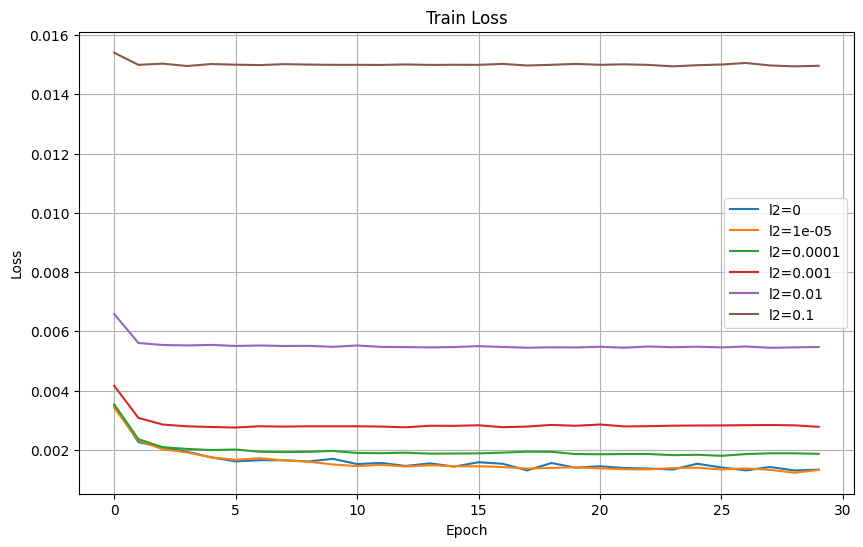

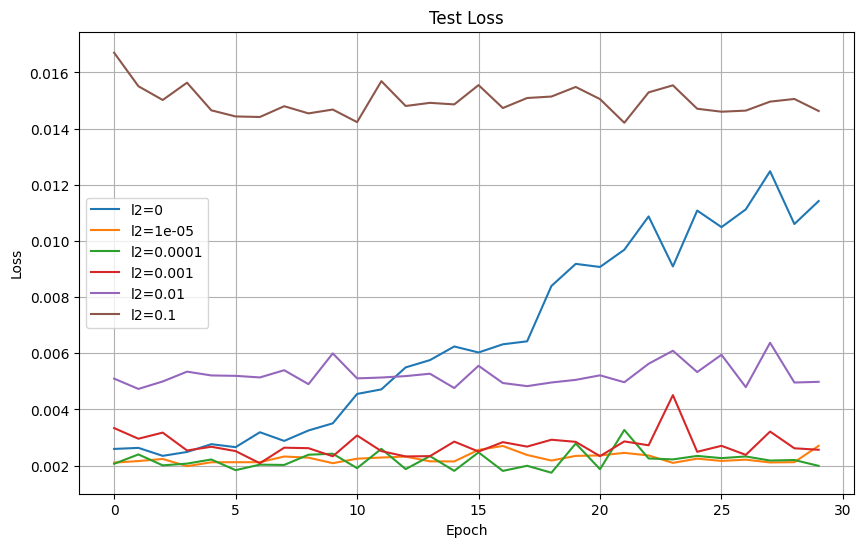

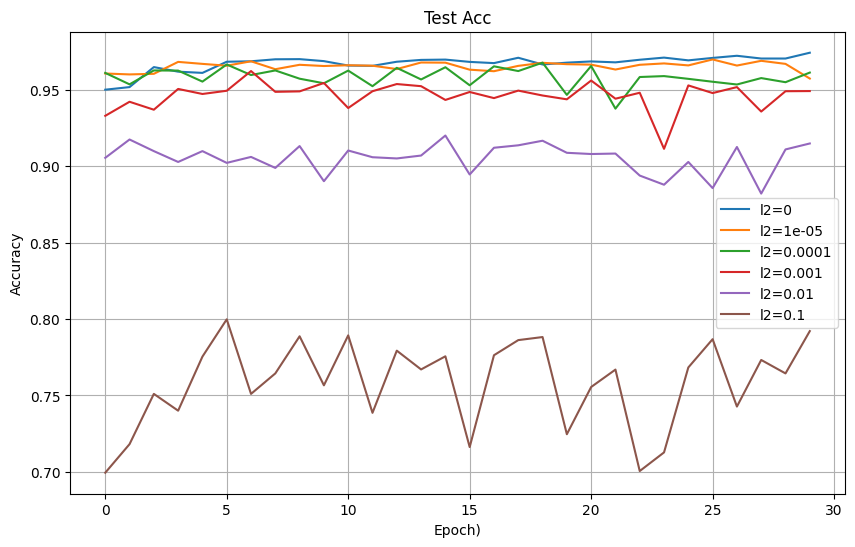

In [8]:
plot_compare(loss_history)

实验结果分析：从损失值曲线可以看出，当正则化系数（lambda）为0，即没有加入L2正则化项时，模型出现过拟合现象，此时训练集的损失逐渐下降，但测试集的损失上升。随着正则化系数增加，L2正则化项的影响逐渐显现，模型在训练集上和测试集的损失略有增加，这是由于L2正则化项对权重参数进行了约束，防止模型过拟合，从而在一定程度上降低了训练集上的拟合能力。需要注意的是，在实际应用中，需要根据具体问题和数据集的特点选择合适的正则化系数，以获得更好的模型泛化能力。